In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Connect to PostgreSQL
db_uri = {db_uri}
engine = create_engine(db_uri)

# Fetch influencer-brand collaborations
query = """
SELECT p.influencer_id, i.username, unnest(string_to_array(pd.brandtags, ', ')) AS brand
FROM post_details pd
JOIN posts p ON pd.post_id = p.post_id
JOIN influencers i ON p.influencer_id = i.influencer_id
WHERE pd.brandtags IS NOT NULL AND pd.brandtags <> '{}';
"""
df = pd.read_sql(query, engine)
engine.dispose()

# Preview data
print(df.head())

   influencer_id      username           brand
0           6811     lovechrys     {missguided
1           6811     lovechrys     missguided}
2           9634      saraemdi  {elixaofficial
3           9634      saraemdi  elixaofficial}
4          24938  rebekahbanks      {yslbeauty


In [16]:
# Keep only top 50 brands by total mentions
top_brands = df["brand"].value_counts().index[:50]

# Keep only top 100 influencers by brand mentions
top_influencers = df["username"].value_counts().index[:100]

# Filter DataFrame
df_filtered = df[df["brand"].isin(top_brands) & df["username"].isin(top_influencers)]

# Create smaller matrix
influencer_brand_matrix = df_filtered.pivot_table(index="username", columns="brand", aggfunc="size", fill_value=0)

In [17]:
from scipy.sparse import csr_matrix

# Convert to sparse matrix
sparse_matrix = csr_matrix(influencer_brand_matrix.values)

# Check size reduction
print(f"Original Size: {influencer_brand_matrix.memory_usage(deep=True).sum() / 1e6} MB")
print(f"Sparse Size: {sparse_matrix.data.nbytes / 1e6} MB")

Original Size: 0.045318 MB
Sparse Size: 0.016856 MB


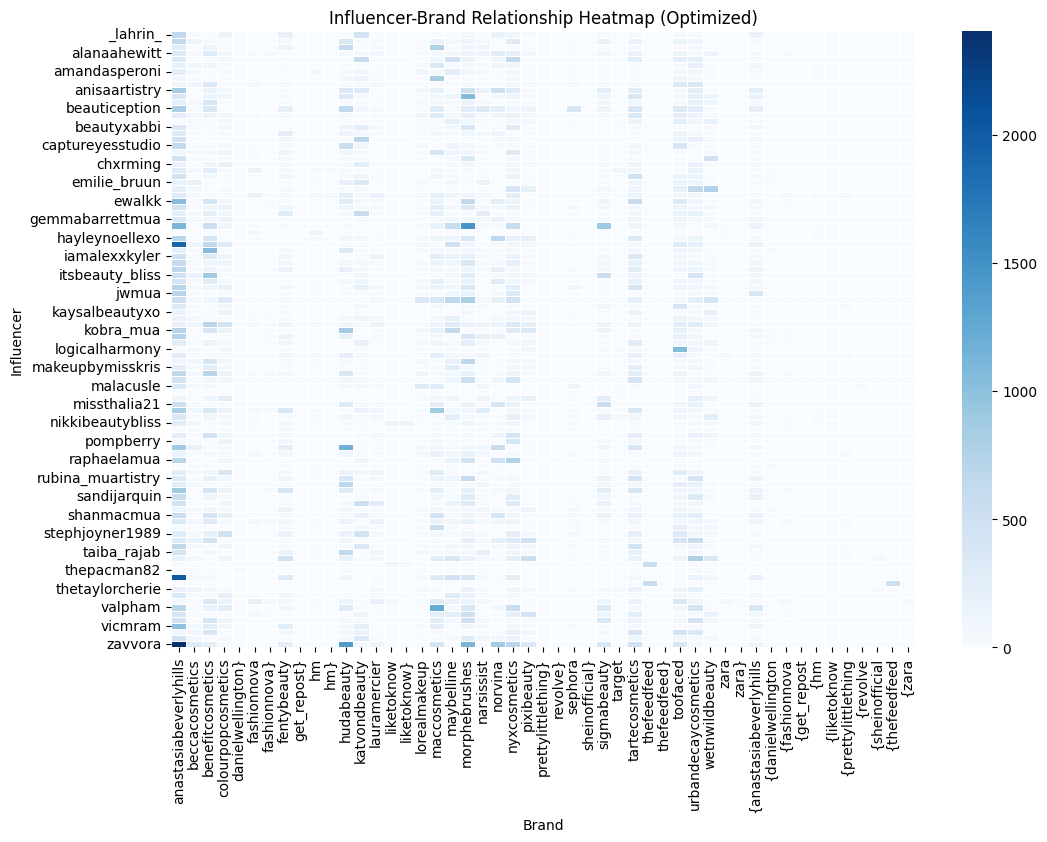

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(influencer_brand_matrix, cmap="Blues", linewidths=0.5, cbar=True)

plt.xlabel("Brand")
plt.ylabel("Influencer")
plt.title("Influencer-Brand Relationship Heatmap (Optimized)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [19]:
# Step 1: Identify Most Popular Brands
top_brands = influencer_brand_matrix.sum(axis=0).sort_values(ascending=False).head(10)

print("🔹 Top 10 Brands Collaborating with Most Influencers:")
print(top_brands, "\n")

# Step 2: Identify Most Active Influencers (Working with Many Brands)
top_influencers = influencer_brand_matrix.sum(axis=1).sort_values(ascending=False).head(10)

print("🔹 Top 10 Influencers Collaborating with Most Brands:")
print(top_influencers, "\n")

# Step 3: Find Brand Pairs That Share the Most Influencers
brand_correlation = influencer_brand_matrix.T.dot(influencer_brand_matrix)

# Exclude self-correlation (brand with itself)
np.fill_diagonal(brand_correlation.values, 0)

# Find top brand pairs
brand_pairs = brand_correlation.unstack().sort_values(ascending=False).head(10)

print("🔹 Top 10 Brand Pairs Sharing the Most Influencers:")
print(brand_pairs, "\n")

# Step 4: Find Influencers Acting as Brand Bridges (Working Across Niches)
influencer_diversity = (influencer_brand_matrix > 0).sum(axis=1)
diverse_influencers = influencer_diversity.sort_values(ascending=False).head(10)

print("🔹 Top 10 Most Cross-Brand Influencers:")
print(diverse_influencers)

🔹 Top 10 Brands Collaborating with Most Influencers:
brand
anastasiabeverlyhills    42374
morphebrushes            19696
benefitcosmetics         16572
nyxcosmetics             15326
maccosmetics             14826
tartecosmetics           14528
hudabeauty               14396
urbandecaycosmetics      13088
toofaced                 12596
maybelline                9846
dtype: int64 

🔹 Top 10 Influencers Collaborating with Most Brands:
username
zavvora                9664
glaminfusion           5928
beautiception          5286
valpham                5084
karlapatriciamakeup    5042
therealmarxicoco       4694
hazelbeauty89          4662
anisaartistry          4488
ewalkk                 4426
theboldbre             4388
dtype: int64 

🔹 Top 10 Brand Pairs Sharing the Most Influencers:
brand                  brand                
morphebrushes          anastasiabeverlyhills    13265896
anastasiabeverlyhills  morphebrushes            13265896
                       hudabeauty               1